In [ ]:
!pip install -r requirements.txt
!pip install -e .

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [2]:
import torch
from PIL import Image
from diffusion_from_scratch.train import DiffusionModel
reverse_xfrm = DiffusionModel.get_reverse_transform()

In [3]:
dm = DiffusionModel(t_steps=1000, epochs=100, dataset_path="data/miyazaki")

In [ ]:
model = dm.train_diffusion_model()
torch.save(model.state_dict(), "data/model_ckpt.pt")

epoch 0 iters 73
train loss: 30.59979021549225
val loss: 30.59979021549225
epoch 1 iters 73
train loss: 7.31860888004303
val loss: 7.31860888004303
epoch 2 iters 73
train loss: 6.328887484967709
val loss: 6.328887484967709
epoch 3 iters 73
train loss: 4.993123983964324
val loss: 4.993123983964324
epoch 4 iters 73
train loss: 4.150268690660596
val loss: 4.150268690660596
epoch 5 iters 73
train loss: 3.633218787610531
val loss: 3.633218787610531
epoch 6 iters 73
train loss: 3.0676508164033294
val loss: 3.0676508164033294
epoch 7 iters 73
train loss: 3.312746458686888
val loss: 3.312746458686888
epoch 8 iters 73
train loss: 3.0919870110228658
val loss: 3.0919870110228658
epoch 9 iters 73
train loss: 3.114902788773179
val loss: 3.114902788773179


In [ ]:
x = torch.randn((8, 3, 64, 64)).to("cuda")
x_denoised = dm.denoise_fully(x, steps=200)

In [8]:
images = [reverse_xfrm(xd) for xd in x_denoised]
grid = image_grid(images, rows=1, cols=len(images))

In [15]:
for x, _ in dm.get_data():
    x = x.to("cuda")
    t = dm.sample_time(x.shape[0]).to("cuda")
    x_noisy, noise = dm.add_noise_one_step(x, t)
    noise_pred = dm.model(x_noisy, t)
    break

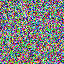

In [16]:
reverse_xfrm = dm.get_reverse_transform()
reverse_xfrm(noise[0])

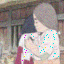

In [17]:
reverse_xfrm(x_noisy[0])

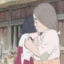

In [18]:
reverse_xfrm(x[0])

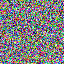

In [19]:
reverse_xfrm(noise_pred[0].detach())

In [ ]:
from torchsummary import summary

In [ ]:
summary(dm.model)

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  1,728
|    |    └─GroupNorm: 3-2               128
|    |    └─GELU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─GroupNorm: 3-5               128
├─Down: 1-2                              --
|    └─Sequential: 2-2                   --
|    |    └─MaxPool2d: 3-6               --
|    |    └─DoubleConv: 3-7              73,984
|    |    └─DoubleConv: 3-8              221,696
|    └─Sequential: 2-3                   --
|    |    └─SiLU: 3-9                    --
|    |    └─Linear: 3-10                 16,512
├─Down: 1-3                              --
|    └─Sequential: 2-4                   --
|    |    └─MaxPool2d: 3-11              --
|    |    └─DoubleConv: 3-12             295,424
|    |    └─DoubleConv: 3-13             885,760
|    └─Sequential: 2-5                 

Layer (type:depth-idx)                   Param #
├─DoubleConv: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  1,728
|    |    └─GroupNorm: 3-2               128
|    |    └─GELU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─GroupNorm: 3-5               128
├─Down: 1-2                              --
|    └─Sequential: 2-2                   --
|    |    └─MaxPool2d: 3-6               --
|    |    └─DoubleConv: 3-7              73,984
|    |    └─DoubleConv: 3-8              221,696
|    └─Sequential: 2-3                   --
|    |    └─SiLU: 3-9                    --
|    |    └─Linear: 3-10                 16,512
├─Down: 1-3                              --
|    └─Sequential: 2-4                   --
|    |    └─MaxPool2d: 3-11              --
|    |    └─DoubleConv: 3-12             295,424
|    |    └─DoubleConv: 3-13             885,760
|    └─Sequential: 2-5                 